In [1]:
# Author: Chandranil Chakraborttii
# Project: Learning I/O Access Patterns to Improve Prefetching in SSDs
# Paper Link :https://www.researchgate.net/profile/Chandranil_Chakraborttii/publication/344379801_Learning_IO_Access_Patterns_to_Improve_Prefetching_in_SSDs/links/5f6e28fba6fdcc00863adb13/Learning-I-O-Access-Patterns-to-Improve-Prefetching-in-SSDs.pdf
# Loading libraries

from keras.models import Sequential, Model
from keras.layers.embeddings import Embedding
from keras.layers import Input, Activation, Dense, Permute, Dropout, add, dot, concatenate
from keras.layers import LSTM
from keras.utils.data_utils import get_file
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from functools import reduce
import pickle
import tarfile
import numpy as np
import re
import os
import time

In [3]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.datasets import imdb


from tensorflow.python.client import device_lib
import numpy as np
import csv
import pandas as pd
import sys
import os
import glob
import tensorflow as tf


os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "2"



In [4]:
# Load all libraries 
# Load data (trace 1) 
# Map, order by frequency 
# Train model 
# Load another data (trace 2)
# Map, order by frequency - Same as trace 1
# Load model
# Use the model to predict on the new trace
# Note and compare results

In [5]:
import numpy as np
import pandas as pd
import glob
import csv
import sys
import os
import math
import tensorflow as tf
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Embedding
from keras.layers import LSTM
from keras.datasets import imdb
from keras.callbacks import EarlyStopping
from sklearn import metrics
from keras.layers.core import Dense, Activation
from keras.callbacks import ModelCheckpoint
from numpy import insert
from sklearn import preprocessing
from collections import Counter
from numpy import array
from numpy import hstack
from keras.preprocessing.sequence import TimeseriesGenerator
import pandas as pd
import operator

# lOADING FIRST TRACE

path  = r"/soe/hlitz/maxwell/notebooks/Prefetching_SSD/Data/output/SYSTOR/part27" 

names = ['TimeStamp','Response','IOType','LUN','ByteOffset','Size']



all_files = glob.glob(os.path.join(path, "2016030819-LUN2.csv"))
print(all_files)




['/soe/hlitz/maxwell/notebooks/Prefetching_SSD/Data/output/SYSTOR/part27/2016030819-LUN2.csv']


In [6]:
df = pd.read_csv(all_files[0],engine='python',skiprows =1,header=None,na_values=['-1'], index_col=False) 
names = ['TimeStamp','Response','IOType','LUN','ByteOffset','Size']   
df.columns = names
#Sorting df by TimeStamp

df = df.sort_values(by=['TimeStamp'])
df.reset_index(inplace=True, drop=True)

print(len(df))

df['ByteOffset_Delta'] = df['ByteOffset'] - df['ByteOffset'].shift(-1)
df = df.drop(df.index[-1])

total_classes = len(Counter(df['ByteOffset_Delta']))
x = Counter(df['ByteOffset_Delta'])
vals = {}
vals =  x.most_common(1000)
bo_list = []
coverage = 0
for key,value in vals:
    bo_list.append(key)
    coverage = coverage + value
print(len(bo_list))
print("Percentage Coverage Delta")
print((coverage/len(df))*100) 


total_classes = len(Counter(df['ByteOffset']))
x = Counter(df['ByteOffset'])
vals = {}
vals =  x.most_common(1000)
bo_list = []
coverage = 0
for key,value in vals:
    bo_list.append(key)
    coverage = coverage + value
    
print(len(bo_list))
print("Percentage Coverage Offset")
print((coverage/len(df))*100)
    
 



2902328
1000
Percentage Coverage Delta
70.70691896536813
1000
Percentage Coverage Offset
69.80925994899955


In [7]:
# Transform Operation_type, Host_name and remove Disk_Num
# Make Class of Byte Offset delta 
# Normalize the columns (Except ByteOffset Delta)
# Make the prediction model with 1000 classes

     
df['ByteOffset_Delta'] = df['ByteOffset_Delta'].fillna(0)
address_map = dict(Counter(df['ByteOffset_Delta']))
sorted_address_map = sorted(dict(address_map).items(), key=operator.itemgetter(1))


In [8]:
sorted_address_map[len(sorted_address_map)-2]

(-32768.0, 82169)

In [9]:
address_remap = {}

count = 0
while(count<len(sorted_address_map)):
    if(count < 1000):
        address_remap[count] = sorted_address_map[len(sorted_address_map)-count - 1][0]
    else:
        address_remap[1001] = sorted_address_map[len(sorted_address_map)-count - 1][0]
    count = count + 1

In [10]:
rev_address_remap = {y:x for x,y in address_remap.items()}

In [11]:
df.head(5)

,TimeStamp,Response,IOType,LUN,ByteOffset,Size,ByteOffset_Delta
0,1.457431e+09,0.005598,R,2,5119596273664,4096,3.686400e+04
1,1.457431e+09,0.004451,R,2,5119596236800,4096,1.342012e+12
2,1.457431e+09,0.000162,W,2,3777583883264,12288,-3.002076e+08
3,1.457431e+09,0.000139,W,2,3777884090880,8192,-1.444479e+09
4,1.457431e+09,0.000148,W,2,3779328570368,8192,1.596548e+09


In [12]:
count = 0
label_list = []
rogue_delta = []
label =0.0
while (count < len(df)):
    x = df['ByteOffset_Delta'].iloc[count]
    if x in rev_address_remap:
        label = rev_address_remap[x]
        label_list.append(label)
    else:
        label_list.append(1001)
        rogue_delta.append(x)
    count = count+1

df['ByteOffset_Delta_class']  = label_list
print(len(Counter(df['ByteOffset_Delta_class'])))
print(len(rogue_delta))

1001
850180


In [13]:
Counter(label_list)[6]

16548

In [14]:
df.head(5)

,TimeStamp,Response,IOType,LUN,ByteOffset,Size,ByteOffset_Delta,ByteOffset_Delta_class
0,1.457431e+09,0.005598,R,2,5119596273664,4096,3.686400e+04,545
1,1.457431e+09,0.004451,R,2,5119596236800,4096,1.342012e+12,1001
2,1.457431e+09,0.000162,W,2,3777583883264,12288,-3.002076e+08,297
3,1.457431e+09,0.000139,W,2,3777884090880,8192,-1.444479e+09,256
4,1.457431e+09,0.000148,W,2,3779328570368,8192,1.596548e+09,249


In [15]:
data_train = df['ByteOffset_Delta_class'].values.tolist()


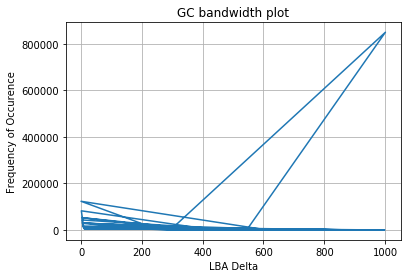

In [16]:
import matplotlib.pyplot as plt
from collections import Counter

y_train = data_train
x = Counter(y_train)
x = dict(x)


plt.plot(list(x.keys()),list(x.values()))

 
plt.xlabel('LBA Delta')
plt.ylabel('Frequency of Occurence')
plt.title('GC bandwidth plot')
plt.grid(True)
plt.show()

In [17]:
top_lba_coverage = (max(list(x.values()))/len(y_test))* 100
print(top_lba_coverage)

40.60842276740984


In [17]:
# lOADING SECOND TRACE
path  = r"/soe/hlitz/maxwell/notebooks/Prefetching_SSD/Data/part49" 

names = ['TimeStamp','Response','IOType','LUN','ByteOffset','Size']



all_files = glob.glob(os.path.join(path, "2016021907-LUN2.csv"))
print(all_files)




df = pd.read_csv(all_files[0],engine='python',skiprows =1,header=None,na_values=['-1'], index_col=False) 
names = ['TimeStamp','Response','IOType','LUN','ByteOffset','Size']   
df.columns = names
#Sorting df by TimeStamp

df = df.sort_values(by=['TimeStamp'])
df.reset_index(inplace=True, drop=True)

print(len(df))

df['ByteOffset_Delta'] = df['ByteOffset'] - df['ByteOffset'].shift(-1)
df = df.drop(df.index[-1])

total_classes = len(Counter(df['ByteOffset_Delta']))
x = Counter(df['ByteOffset_Delta'])
vals = {}
vals =  x.most_common(1000)
bo_list = []
coverage = 0
for key,value in vals:
    bo_list.append(key)
    coverage = coverage + value
print(len(bo_list))
print("Percentage Coverage Delta")
print((coverage/len(df))*100) 


total_classes = len(Counter(df['ByteOffset']))
x = Counter(df['ByteOffset'])
vals = {}
vals =  x.most_common(1000)
bo_list = []
coverage = 0
for key,value in vals:
    bo_list.append(key)
    coverage = coverage + value
    
print(len(bo_list))
print("Percentage Coverage Offset")
print((coverage/len(df))*100)
    
# Make the prediction model with 1000 classes

     
df['ByteOffset_Delta'] = df['ByteOffset_Delta'].fillna(0)
address_map = dict(Counter(df['ByteOffset_Delta']))
sorted_address_map = sorted(dict(address_map).items(), key=operator.itemgetter(1))

 



['/soe/hlitz/maxwell/notebooks/Prefetching_SSD/Data/part49/2016021907-LUN2.csv']
41749
1000
Percentage Coverage Delta
77.65641467854748
1000
Percentage Coverage Offset
7.5500622784325


In [18]:
address_remap = {}

count = 0
while(count<len(sorted_address_map)):
    if(count < 1000):
        address_remap[count] = sorted_address_map[len(sorted_address_map)-count - 1][0]
    else:
        address_remap[1001] = sorted_address_map[len(sorted_address_map)-count - 1][0]
    count = count + 1

rev_address_remap = {y:x for x,y in address_remap.items()}

count = 0
label_list = []
rogue_delta = []
label =0.0
while (count < len(df)):
    x = df['ByteOffset_Delta'].iloc[count]
    if x in rev_address_remap:
        label = rev_address_remap[x]
        label_list.append(label)
    else:
        label_list.append(1001)
        rogue_delta.append(x)
    count = count+1

df['ByteOffset_Delta_class']  = label_list
print(len(Counter(df['ByteOffset_Delta_class'])))
print(len(rogue_delta))

data_path  = r'/soe/cchakrab/test_output/output_csv/SYSTOR/test'

data_test = df['ByteOffset_Delta_class'].values.tolist()


1001
9327


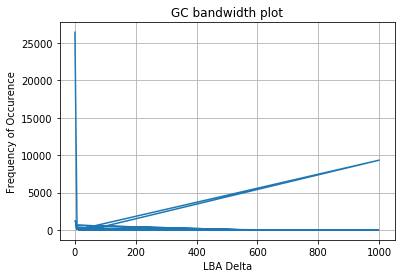

In [19]:
import matplotlib.pyplot as plt
from collections import Counter

y_test = data_test
x = Counter(y_test)
x = dict(x)


plt.plot(list(x.keys()),list(x.values()))

 
plt.xlabel('LBA Delta')
plt.ylabel('Frequency of Occurence')
plt.title('GC bandwidth plot')
plt.grid(True)
plt.show()

In [20]:
path_train  = r"/soe/cchakrab/test_output/output_csv/SYSTOR/test/train_run1_transfer.txt"

with open(path_train, 'w') as f:
    for item in data_train:
        f.write("%s " % item)
        


In [21]:
path_test  = r"/soe/cchakrab/test_output/output_csv/SYSTOR/test/test_run1_transfer.txt"
with open(path_test, 'w') as f:
    for item in data_test:
        f.write("%s " % item)

In [22]:
import collections
import os
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Embedding, Dropout, TimeDistributed
from keras.layers import LSTM
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import numpy as np
import argparse



def read_words(filename):
    with open(filename, 'r') as f:
        return f.read().split()

def build_vocab(filename):
    data = read_words(filename)

    counter = collections.Counter(data)
    count_pairs = sorted(counter.items(), key=lambda x: (-x[1], x[0]))

    words, _ = list(zip(*count_pairs))
    word_to_id = dict(zip(words, range(len(words))))

    return word_to_id


def file_to_word_ids(filename, word_to_id):
    data = read_words(filename)
    return [word_to_id[word] for word in data if word in word_to_id]


def load_data():
    # get the data paths
    train_path = os.path.join(data_path, "train_run1_transfer.txt")
    test_path = os.path.join(data_path, "test_run1_transfer.txt")

    # build the complete vocabulary, then convert text data to list of integers
    word_to_id = build_vocab(train_path)
    train_data = file_to_word_ids(train_path, word_to_id)
    test_data = file_to_word_ids(test_path, word_to_id)
    vocabulary = len(word_to_id)
    reversed_dictionary = dict(zip(word_to_id.values(), word_to_id.keys()))

    print(train_data[:5])
    #print(word_to_id)
    print(vocabulary)
    print(" ".join([reversed_dictionary[x] for x in train_data[:10]]))
    return train_data, test_data, vocabulary, reversed_dictionary


In [23]:
train_data, test_data, vocabulary, reversed_dictionary = load_data()

[546, 0, 298, 257, 250]
1001
545 1001 297 256 249 0 1001 1001 1001 1001


In [24]:
class KerasBatchGenerator(object):

    def __init__(self, data, num_steps, batch_size, vocabulary, skip_step=5):
        self.data = data
        self.num_steps = num_steps
        self.batch_size = batch_size
        self.vocabulary = vocabulary
        # this will track the progress of the batches sequentially through the
        # data set - once the data reaches the end of the data set it will reset
        # back to zero
        self.current_idx = 0
        # skip_step is the number of words which will be skipped before the next
        # batch is skimmed from the data set
        self.skip_step = skip_step

    def generate(self):
        x = np.zeros((self.batch_size, self.num_steps))
        y = np.zeros((self.batch_size, self.num_steps, self.vocabulary))
        while True:
            for i in range(self.batch_size):
                if self.current_idx + self.num_steps >= len(self.data):
                    # reset the index back to the start of the data set
                    self.current_idx = 0
                x[i, :] = self.data[self.current_idx:self.current_idx + self.num_steps]
                temp_y = self.data[self.current_idx + 1:self.current_idx + self.num_steps + 1]
                # convert all of temp_y into a one hot representation
                y[i, :, :] = to_categorical(temp_y, num_classes=self.vocabulary)
                self.current_idx += self.skip_step
            yield x, y


In [25]:
from keras.callbacks import EarlyStopping

num_steps = 64
batch_size = 64

train_data_generator = KerasBatchGenerator(train_data, num_steps, batch_size, vocabulary, skip_step=num_steps) 
#valid_data_generator = KerasBatchGenerator(valid_data, num_steps, batch_size, vocabulary, skip_step=num_steps)
test_data_generator = KerasBatchGenerator(test_data, num_steps, batch_size, vocabulary, skip_step=num_steps)

hidden_size = 1500 
use_dropout=True 

model = Sequential()
model.add(Embedding(vocabulary, hidden_size, input_length=num_steps))
model.add(LSTM(hidden_size, return_sequences=True))
model.add(LSTM(hidden_size, return_sequences=True))
if use_dropout:
    model.add(Dropout(0.2))
model.add(TimeDistributed(Dense(vocabulary)))
model.add(Activation('softmax'))


optimizer = Adam()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

print(model.summary())
monitor = EarlyStopping(monitor='val_categorical_accuracy', min_delta=1e-3, patience=15, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath=data_path + '/model-{epoch:02d}.hdf5', verbose=1)
num_epochs = 5000

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 64, 1500)          1501500   
_________________________________________________________________
lstm_1 (LSTM)                (None, 64, 1500)          18006000  
_________________________________________________________________
lstm_2 (LSTM)                (None, 64, 1500)          18006000  
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 1500)          0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 64, 1001)          1502501   
_________________________________________________________________
activation_1 (Activation)    (None, 64, 1001)          0         
Total params: 39,016,001
Trainable params: 39,016,001
Non-trainable params: 0
__________________________________________

In [26]:
model.fit_generator(train_data_generator.generate(), len(train_data)//(batch_size*num_steps), num_epochs,
                        validation_data=test_data_generator.generate(),
                        validation_steps=len(train_data)//(batch_size*num_steps), callbacks=[checkpointer,monitor])



/soe/hlitz/miniconda3/envs/py3_tf_gpu/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/5000
708/708 [==============================] - 328s 464ms/step - loss: 2.1358 - categorical_accuracy: 0.6167 - val_loss: 3.7007 - val_categorical_accuracy: 0.2314

Epoch 00001: saving model to /soe/cchakrab/test_output/output_csv/SYSTOR/test/model-01.hdf5
Epoch 2/5000
708/708 [==============================] - 326s 461ms/step - loss: 0.9556 - categorical_accuracy: 0.7887 - val_loss: 3.4581 - val_categorical_accuracy: 0.6402

Epoch 00002: saving model to /soe/cchakrab/test_output/output_csv/SYSTOR/test/model-02.hdf5
Epoch 3/5000
708/708 [==============================] - 327s 462ms/step - loss: 0.8191 - categorical_accuracy: 0.8053 - val_loss: 2.2883 - val_categorical_accuracy: 0.6926

Epoch 00003: saving model to /soe/cchakrab/test_output/output_csv/SYSTOR/test/model-03.hdf5
Epoch 4/5000
708/708 [==============================] - 327s 462ms/step - loss: 0.7899 - categorical_accuracy: 0.8092 - val_loss: 3.1561 - val_categorical_accuracy: 0.7326

Epoch 00004: saving model to /so

KeyboardInterrupt: 

In [ ]:
print("Model trained!")

In [27]:
model = load_model(data_path + "/model-12.hdf5")

/soe/hlitz/miniconda3/envs/py3_tf_gpu/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [28]:
import time
start_time = time.time()

samples = (len(data_test)/batch_size)
score = model.evaluate_generator(test_data_generator.generate(), samples)
print("Loss: ", score[0], "Accuracy: ", score[1])
    
print("--- %s seconds ---" % (time.time() - start_time))


Loss:  1.7719885110855103 Accuracy:  0.7378326058387756
--- 92.01937174797058 seconds ---


In [29]:
# import time
# start_time = time.time()


# predict = model.predict_generator(test_data_generator.generate(),samples)
# print("--- %s seconds ---" % (time.time() - start_time))


--- 82.40729761123657 seconds ---


In [30]:
# import time
# start_time = time.time()


# predicted_class_indices=np.argmax(predict,axis=1)
# print("--- %s seconds ---" % (time.time() - start_time))


--- 13.9371497631073 seconds ---


In [31]:
# import time
# start_time = time.time()

# dummy_iters = 31
# output_generator = KerasBatchGenerator(test_data, num_steps, 1, vocabulary,
#                                                      skip_step=1)
# print("Generating Output data:")
# for i in range(dummy_iters):
#     dummy = next(output_generator.generate())

# true_print_out = []
# pred_print_out = []

# status = 0
# num_predict = len(test_data)
# for i in range(num_predict):
#     data = next(output_generator.generate())
#     prediction = model.predict(data[0])
#     predict_word = np.argmax(prediction[:, num_steps-1, :])
#     true_print_out.append(reversed_dictionary[train_data[num_steps + dummy_iters + i]])
#     pred_print_out.append(reversed_dictionary[predict_word])
#     status =status+1
#     if(status%1000 == 0 and status >1000):
#         print(status/len((test_data)))
# print("--- %s seconds ---" % (time.time() - start_time))

Generating Output data:
0.04790648653827728
0.07185972980741592
0.09581297307655456
0.1197662163456932
0.14371945961483185
0.1676727028839705
0.19162594615310913
0.21557918942224777
0.2395324326913864
0.2634856759605251
0.2874389192296637
0.31139216249880236
0.335345405767941
0.35929864903707964
0.38325189230621826
0.4072051355753569
0.43115837884449554
0.4551116221136342
0.4790648653827728
0.5030181086519114
0.5269713519210502
0.5509245951901888
0.5748778384593274
0.598831081728466
0.6227843249976047
0.6467375682667433
0.670690811535882
0.6946440548050206
0.7185972980741593
0.7425505413432979
0.7665037846124365
0.7904570278815751
0.8144102711507138
0.8383635144198525
0.8623167576889911
0.8862700009581297
0.9102232442272684
0.934176487496407
0.9581297307655456
0.9820829740346843
--- 3961.102870464325 seconds ---


In [32]:
from sklearn.metrics import accuracy_score
print(accuracy_score(true_print_out, pred_print_out))

0.143575740155217


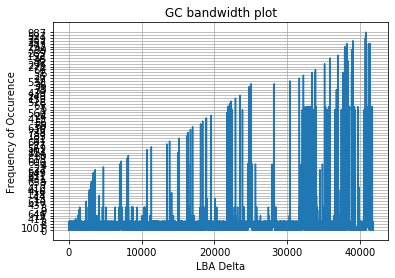

In [34]:
import matplotlib.pyplot as plt
from collections import Counter


plt.plot(pred_print_out)

 
plt.xlabel('LBA Delta')
plt.ylabel('Frequency of Occurence')
plt.title('GC bandwidth plot')
plt.grid(True)
plt.show()